<a href="https://colab.research.google.com/github/SayanDas07/NITDGP-KWS-using-FewShortLearning/blob/main/FinalKWSBaseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jun 17 06:47:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p data_10_wav/data

In [ ]:
!wget -O speech_commands_v0.02.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2025-06-17 06:47:30--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.11.207, 192.178.219.207, 74.125.134.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.11.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   233MB/s    in 17s     

2025-06-17 06:47:47 (139 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [ ]:
!tar -xzf speech_commands_v0.02.tar.gz -C data_10_wav/data

In [ ]:
DATASET_PATH = "data_10_wav/data/"
save_path = "/content/drive/MyDrive/NITDGP/Base Model Variations/UnknownIs3000"

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import librosa

In [ ]:
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

In [ ]:
SAMPLES_TO_CONSIDER = 16000
frame_length = int(SAMPLES_TO_CONSIDER * (32 / 1000))
hop_length = int(SAMPLES_TO_CONSIDER * (16 / 1000))
MAX_UNKNOWN = 3000
UNKNOWN_PER_FOLDER_LIMIT = 135
unknown_count = 0
EXAMPLES_PER_FOLDER = 2

In [ ]:
labels = []
log_mel_spectrograms = []

In [ ]:
print(labels)

[]


In [ ]:
keyword_list = ['off', 'left', 'down', 'up', 'go', 'on', 'stop', 'unknown', 'right', 'yes']
keyword_index_dict = {k: i for i, k in enumerate(keyword_list)}
print("Keyword Index Mapping:", keyword_index_dict)

Keyword Index Mapping: {'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5, 'stop': 6, 'unknown': 7, 'right': 8, 'yes': 9}


In [ ]:
from collections import defaultdict
class_sample_counts = defaultdict(int)
unknown_folder_counts = defaultdict(int)
unknown_folder_examples = defaultdict(list)

In [ ]:
def hamming_window(length):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(length) / (length - 1))

In [ ]:
exclude_from_unknown = ['tree', 'marvin', 'one']

for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    if dirpath != DATASET_PATH:
        label = os.path.basename(dirpath)
        if label == '_background_noise_':
            continue

        # 👇 Skip if the folder is in exclude list
        if label in exclude_from_unknown:
            continue

        final_label = label if label in keyword_list else 'unknown'
        print(f"\nProcessing: '{label}' as '{final_label}'")

        per_class_count = 0
        filenames.sort()

        for f in filenames:
            if final_label == 'unknown':
                if unknown_count >= MAX_UNKNOWN:
                    break
                if per_class_count >= UNKNOWN_PER_FOLDER_LIMIT:
                    break

            file_path = os.path.join(dirpath, f)
            try:
                signal, sample_rate = librosa.load(file_path, sr=16000)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                continue

            if len(signal) >= SAMPLES_TO_CONSIDER:
                signal = signal[:SAMPLES_TO_CONSIDER]
            else:
                signal = np.pad(signal, (SAMPLES_TO_CONSIDER - len(signal), 0), mode='constant')

            signal = signal.astype(np.float32)
            windowed_signal = signal * hamming_window(SAMPLES_TO_CONSIDER)

            mel_spec = librosa.feature.melspectrogram(
                y=windowed_signal,
                sr=16000,
                n_mels=40,
                n_fft=frame_length,
                win_length=frame_length,
                hop_length=hop_length,
                center=False
            )

            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            log_mel_spectrograms.append(log_mel_spec.T)
            labels.append(keyword_index_dict[final_label])

            per_class_count += 1
            class_sample_counts[final_label] += 1

            if final_label == 'unknown':
                unknown_count += 1
                folder_name = os.path.basename(dirpath)
                unknown_folder_counts[folder_name] += 1
                if len(unknown_folder_examples[folder_name]) < EXAMPLES_PER_FOLDER:
                    unknown_folder_examples[folder_name].append(log_mel_spec)

            if per_class_count >= 3000 and final_label != 'unknown':
                print(f"{final_label} : {keyword_index_dict[final_label]} = {per_class_count}")
                print(log_mel_spec.T.shape)
                break

print(f"\n✅ Final 'unknown' sample count: {unknown_count}")
print("\n📦 Sample count per class:")
for k, v in class_sample_counts.items():
    print(f"'{k}': {v}")



Processing: 'learn' as 'unknown'

Processing: 'stop' as 'stop'
stop : 6 = 3000
(61, 40)

Processing: 'zero' as 'unknown'

Processing: 'five' as 'unknown'

Processing: 'on' as 'on'
on : 5 = 3000
(61, 40)

Processing: 'follow' as 'unknown'

Processing: 'wow' as 'unknown'

Processing: 'eight' as 'unknown'

Processing: 'up' as 'up'
up : 3 = 3000
(61, 40)

Processing: 'sheila' as 'unknown'

Processing: 'four' as 'unknown'

Processing: 'down' as 'down'
down : 2 = 3000
(61, 40)

Processing: 'yes' as 'yes'
yes : 9 = 3000
(61, 40)

Processing: 'six' as 'unknown'

Processing: 'off' as 'off'
off : 0 = 3000
(61, 40)

Processing: 'backward' as 'unknown'

Processing: 'happy' as 'unknown'

Processing: 'house' as 'unknown'

Processing: 'two' as 'unknown'

Processing: 'three' as 'unknown'

Processing: 'visual' as 'unknown'

Processing: 'no' as 'unknown'

Processing: 'bed' as 'unknown'

Processing: 'bird' as 'unknown'

Processing: 'seven' as 'unknown'

Processing: 'right' as 'right'
right : 8 = 3000
(6

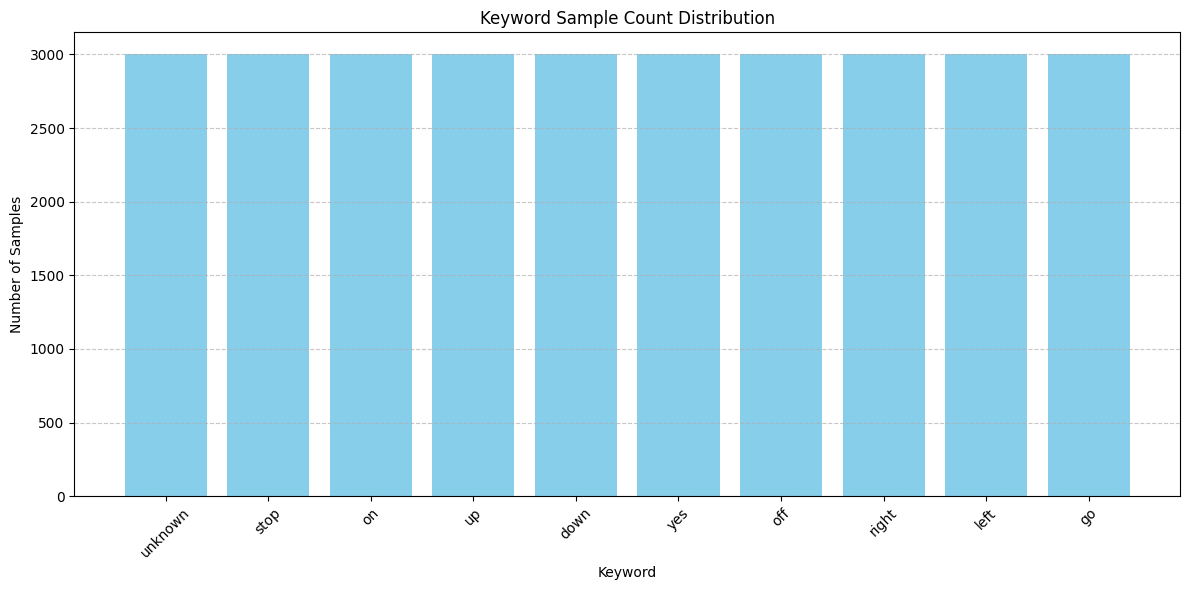

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(class_sample_counts.keys(), class_sample_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Keyword Sample Count Distribution")
plt.xlabel("Keyword")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

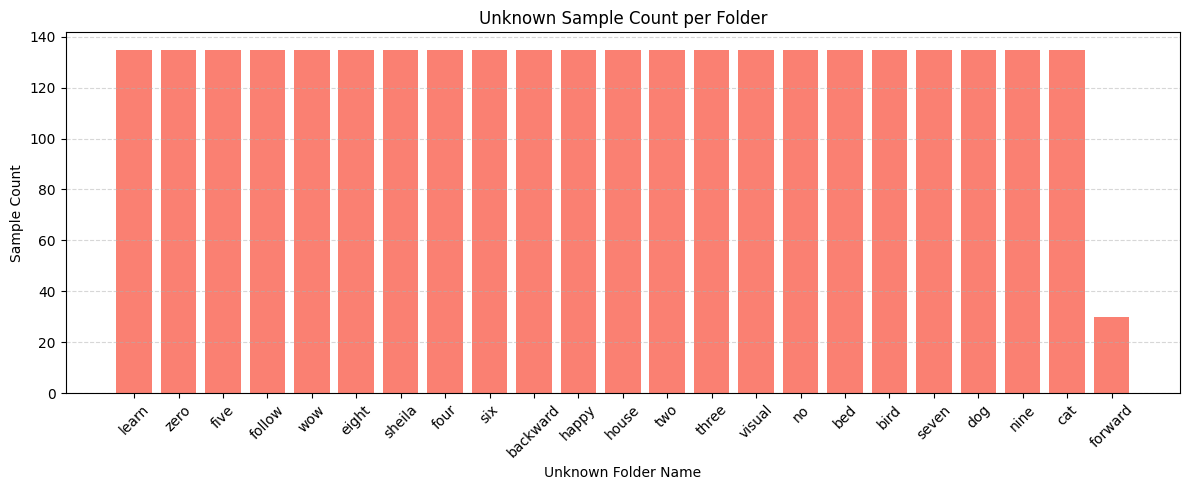

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(unknown_folder_counts.keys(), unknown_folder_counts.values(), color='salmon')
plt.title("Unknown Sample Count per Folder")
plt.xlabel("Unknown Folder Name")
plt.ylabel("Sample Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import librosa.display
def plot_mel_spectrogram(spec, label_idx):
    plt.figure(figsize=(6, 4))
    plt.imshow(spec.T, aspect='auto', origin='lower')
    plt.title(f"Label: {keyword_list[label_idx]}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


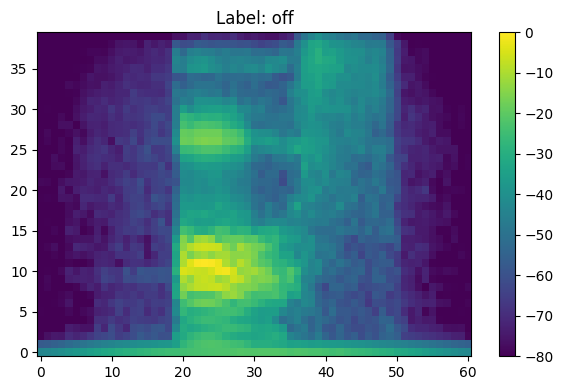

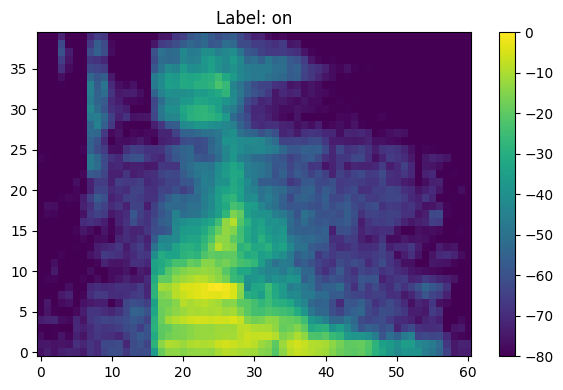

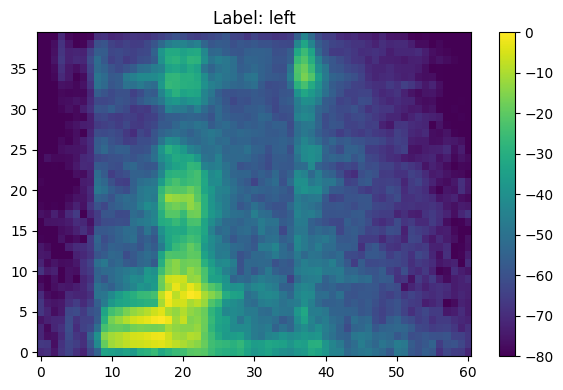

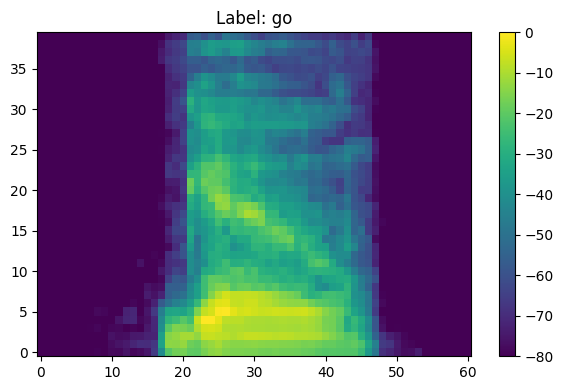

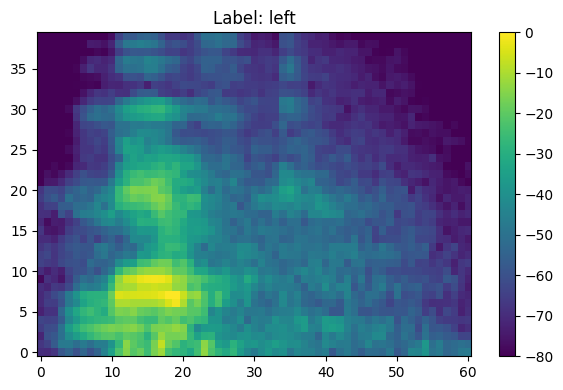

In [ ]:
import random

for _ in range(5):
    idx = random.randint(0, len(log_mel_spectrograms) - 1)
    plot_mel_spectrogram(log_mel_spectrograms[idx], labels[idx])



In [ ]:
np.save(os.path.join(save_path, 'X_log_mel_spectrograms_base_UK3000.npy'), np.array(log_mel_spectrograms))
np.save(os.path.join(save_path, 'y_log_mel_spectrograms_base_UK3000.npy'), np.array(labels))
print("Feature extraction done and saved.")


Feature extraction done and saved.


In [ ]:
X = np.load(os.path.join(save_path, 'X_log_mel_spectrograms_base_UK3000.npy'))
y = np.load(os.path.join(save_path, 'y_log_mel_spectrograms_base_UK3000.npy'))

In [ ]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)


X shape: (30000, 61, 40)
y shape: (30000,)


In [ ]:
from collections import Counter
label_map = { 'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5,
              'stop': 6, 'unknown': 7, 'right': 8, 'yes': 9 }

inv_label_map = {v: k for k, v in label_map.items()}
label_counts = Counter(y)
for label_idx in sorted(label_counts):
    label_name = inv_label_map.get(label_idx, 'unknown')
    print(f"{label_name}: {label_counts[label_idx]} samples")

off: 3000 samples
left: 3000 samples
down: 3000 samples
up: 3000 samples
go: 3000 samples
on: 3000 samples
stop: 3000 samples
unknown: 3000 samples
right: 3000 samples
yes: 3000 samples


In [ ]:
# Normalize
X = np.array([x / np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else x for x in X])


X = np.squeeze(X)  # removes all dimensions of size 1, if any
if X.ndim == 3:
    X = X[..., np.newaxis]  # adds only (61, 40, 1) as required
CLASSES = len(keyword_list)
y_cat = to_categorical(y, CLASSES)

In [ ]:
len(keyword_list)

10

In [ ]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)

X shape: (30000, 61, 40, 1)
y shape: (30000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=np.argmax(y_train, axis=1), random_state=42
)

In [ ]:
def build_model(hparams):
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    filters = hparams['filters']
    kernel_size = hparams['kernel_size']
    use_bn = hparams['use_bn']
    num_res_blocks = hparams['residual_blocks']
    num_fc_layers = hparams['fc_layers']
    use_dropout = hparams['use_dropout']

    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Initial Conv Block
    x = layers.Conv2D(filters, kernel_size, padding='same')(inputs)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="relu1_1")(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="relu1_2")(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    # Residual Blocks
    for block_idx in range(num_res_blocks):
        # Skip projection with BN
        skip = layers.Conv2D(filters * 2, (1,1), strides=(2,2), padding='same')(x)
        skip = layers.BatchNormalization()(skip)

        # Residual path
        y = layers.Conv2D(filters * 2, kernel_size, padding='same')(x)
        if use_bn:
            y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)

        y = layers.Conv2D(filters * 2, kernel_size, padding='same')(y)
        if use_bn:
            y = layers.BatchNormalization()(y)

        y = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(y)

        # Add and ReLU
        x = layers.add([y, skip])
        x = layers.ReLU(name=f"res_relu_{block_idx}")(x)

        filters *= 2  # Double filters

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name="gap")(x)

    # Dense layers
    fc_config = {
        1: [64],
        2: [128, 64],
        3: [256, 128, 64],
        4: [512, 256, 128, 64]
    }

    for i, units in enumerate(fc_config[num_fc_layers]):
        x = layers.Dense(units, activation='relu', name=f"fc{i+1}")(x)
        if use_dropout:
            x = layers.Dropout(0.3, name=f"dropout{i+1}")(x)

    outputs = layers.Dense(CLASSES, activation='softmax', name="output_layer")(x)
    return Model(inputs, outputs, name="FixedCNN")


In [ ]:
hparams = {
    'filters': 32,
    'kernel_size': 5,
    'use_bn': False,
    'residual_blocks': 1,
    'fc_layers': 4,
    'use_dropout': True
}

In [ ]:
model = build_model(hparams)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "FixedCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 61, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 61, 40,    │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1_1 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 40,    │     25,632 │ relu1_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1_2 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 20,    │          0 │ relu1_2[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 31, 20,    │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 31, 20,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 20,    │    102,464 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 10,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 10,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 10,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 10,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_relu_0 (ReLU)   │ (None, 16, 10,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 64)        │          0 │ res_relu_0[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 512)       │     33,280 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 512)       │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 388,970 (1.48 MB)

 Trainable params: 388,842 (1.48 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stop])

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.1467 - loss: 2.2226 - val_accuracy: 0.2635 - val_loss: 1.9277
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3293 - loss: 1.6649 - val_accuracy: 0.5027 - val_loss: 1.2417
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5761 - loss: 1.1089 - val_accuracy: 0.6954 - val_loss: 0.7715
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7190 - loss: 0.7832 - val_accuracy: 0.8046 - val_loss: 0.5775
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8273 - loss: 0.5414 - val_accuracy: 0.8623 - val_loss: 0.4088
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8530 - loss: 0.4667 - val_accuracy: 0.8677 - val_loss: 0.4160
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8815 - loss: 0.3875 - val_accuracy: 0.8960 - val_loss: 0.3269
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8948 - loss: 0.3515 - val_

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9344 - loss: 0.2014

Test Accuracy: 93.43%


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

penultimate_layer = model.get_layer("fc4").output
feature_model = Model(inputs=model.input, outputs=penultimate_layer)

features = feature_model.predict(X_test, batch_size=64)
true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class index

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


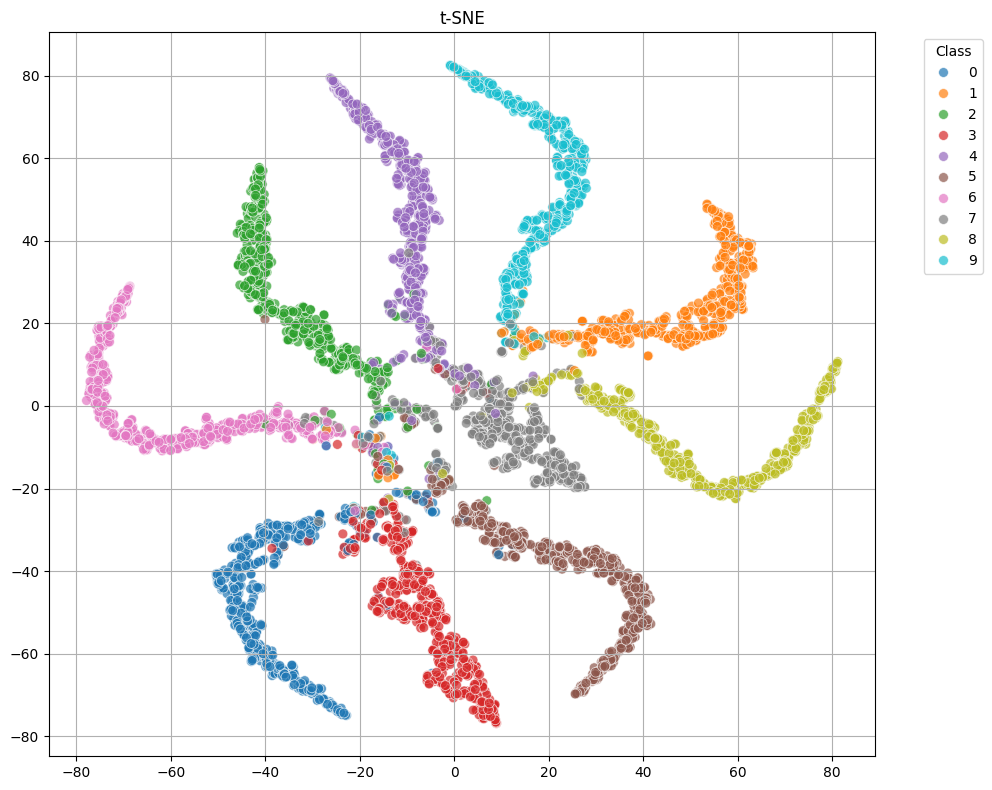

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_tsne = tsne.fit_transform(features)

# Create distinct colors for each class
num_classes = len(np.unique(true_labels))
palette = sns.color_palette("tab10", n_colors=num_classes)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=features_tsne[:, 0],
    y=features_tsne[:, 1],
    hue=true_labels,
    palette=palette,
    s=50,
    alpha=0.7
)
plt.title("t-SNE")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

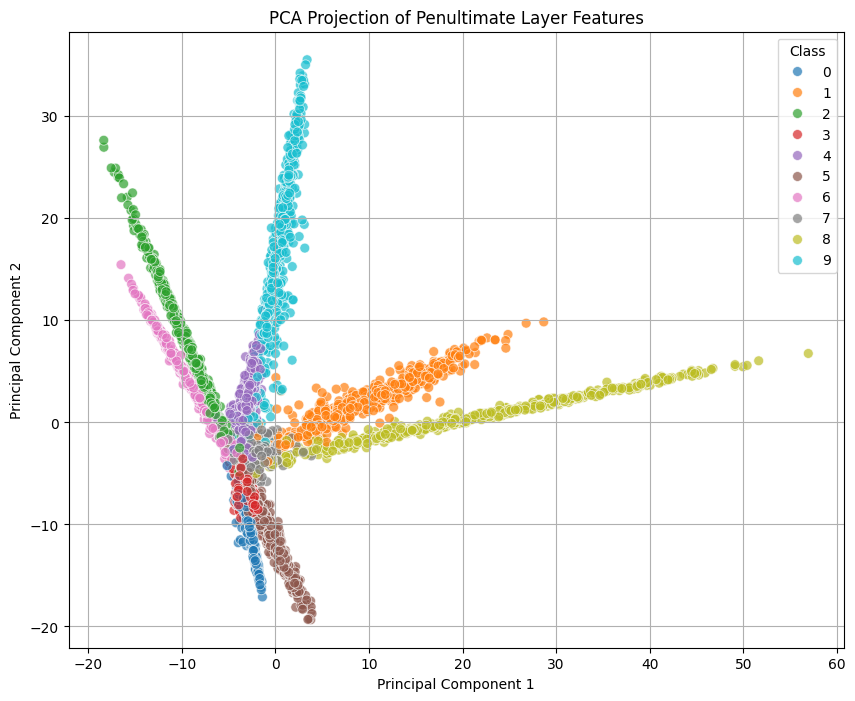

In [ ]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=true_labels, palette='tab10', s=50, alpha=0.7)
plt.title("PCA Projection of Penultimate Layer Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


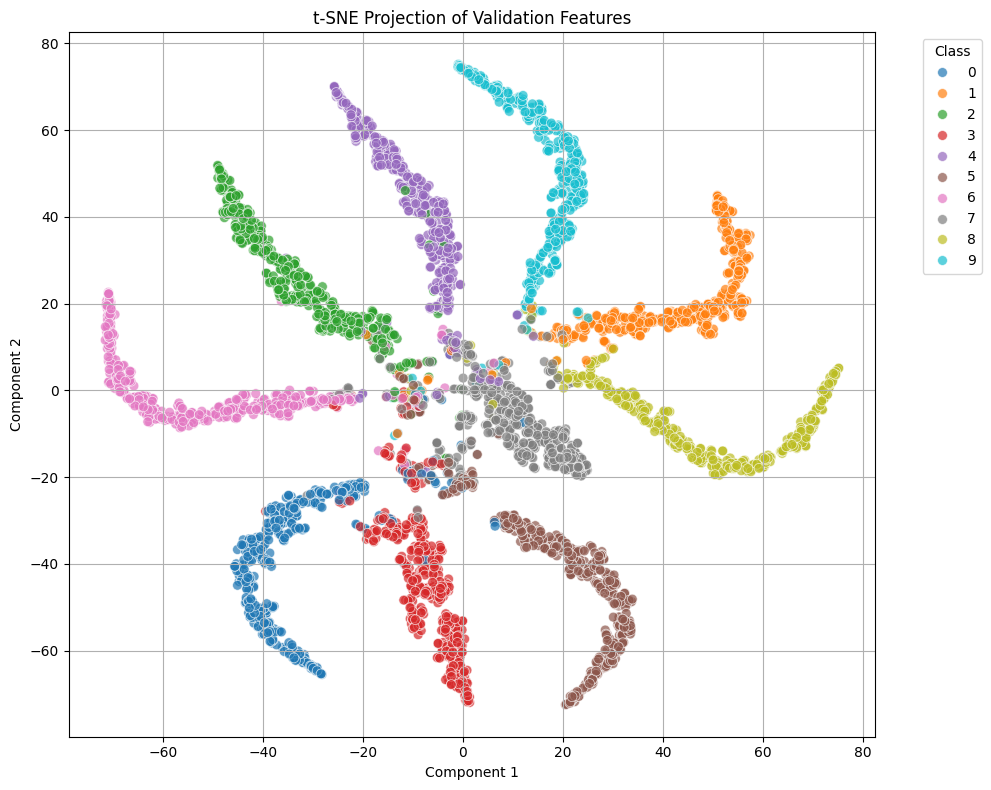

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Model

# Get penultimate layer output (fc4)
penultimate_output_layer = model.get_layer("fc4").output
val_feature_extractor = Model(inputs=model.input, outputs=penultimate_output_layer)

# Extract features for X_val
val_penultimate_features = val_feature_extractor.predict(X_val, batch_size=64)
val_class_indices = np.argmax(y_val, axis=1)  # One-hot to class index

# Run t-SNE on validation features
val_tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
val_tsne_result = val_tsne_model.fit_transform(val_penultimate_features)

# Generate color palette
val_num_classes = len(np.unique(val_class_indices))
val_color_palette = sns.color_palette("tab10", n_colors=val_num_classes)

# Plot t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=val_tsne_result[:, 0],
    y=val_tsne_result[:, 1],
    hue=val_class_indices,
    palette=val_color_palette,
    s=50,
    alpha=0.7
)
plt.title("t-SNE Projection of Validation Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_true_classes, y_pred_classes, target_names=keyword_list))

              precision    recall  f1-score   support

         off       0.90      0.94      0.92       600
        left       0.94      0.96      0.95       600
        down       0.92      0.93      0.92       600
          up       0.94      0.91      0.93       600
          go       0.93      0.94      0.93       600
          on       0.94      0.95      0.94       600
        stop       0.92      0.98      0.95       600
     unknown       0.89      0.83      0.86       600
       right       0.99      0.95      0.97       600
         yes       0.98      0.96      0.97       600

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



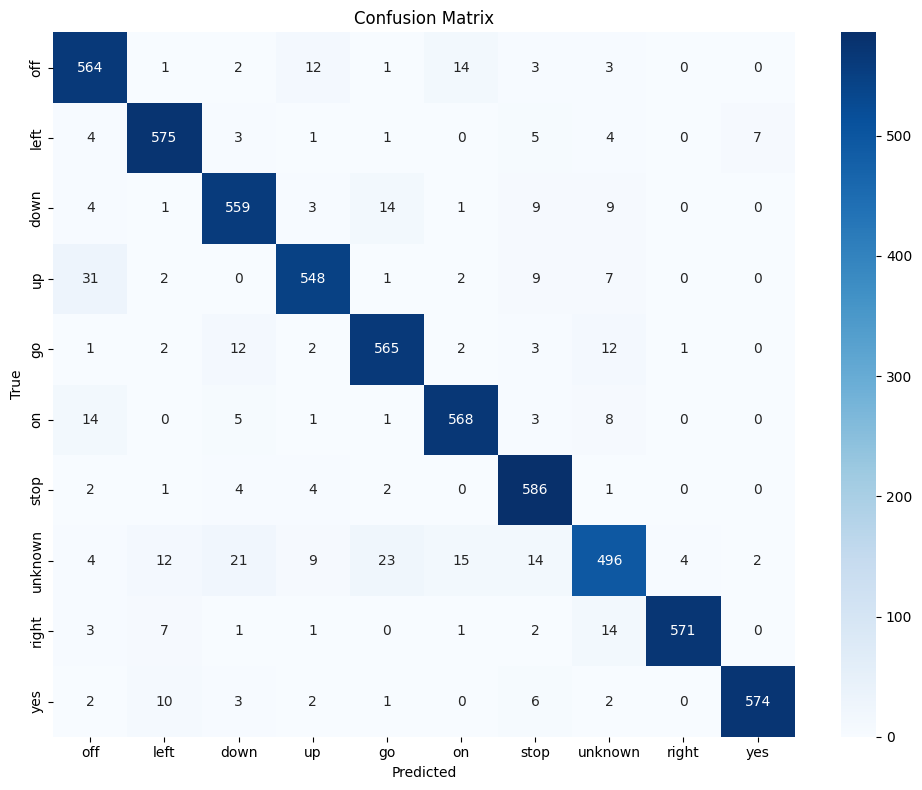

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=keyword_list, yticklabels=keyword_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



In [ ]:

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (19200, 61, 40, 1)
y_train: (19200, 10)
X_test: (6000, 61, 40, 1)
y_test: (6000, 10)


In [ ]:
model.save(os.path.join(save_path, 'CNN_BASE_UK3000.h5'))

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


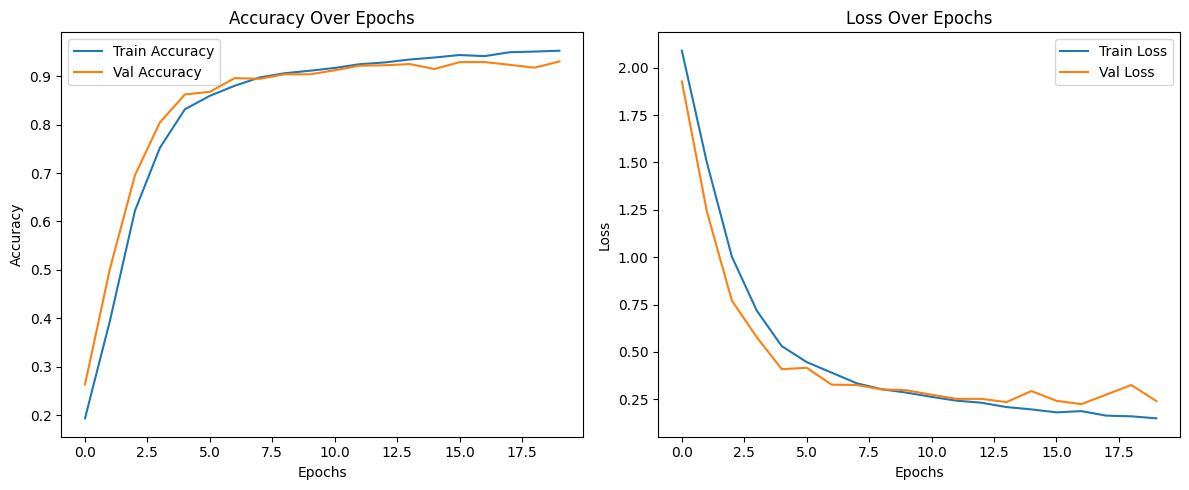

In [ ]:
plot_training_history(history)

In [ ]:
def extract_features_from_file(file_path):
    try:
        signal, _ = librosa.load(file_path, sr=16000)
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

    if len(signal) >= SAMPLES_TO_CONSIDER:
        signal = signal[:SAMPLES_TO_CONSIDER]
    else:
        signal = np.pad(signal, (SAMPLES_TO_CONSIDER - len(signal), 0), mode='constant')

    signal = signal.astype(np.float32)
    windowed = signal * hamming_window(SAMPLES_TO_CONSIDER)

    mel_spec = librosa.feature.melspectrogram(
        y=windowed,
        sr=16000,
        n_mels=40,
        n_fft=frame_length,
        win_length=frame_length,
        hop_length=hop_length,
        center=False
    )

    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    feature = log_mel.T

    # Normalize like training
    feature = feature / np.max(np.abs(feature))

    # Add channel dim
    if feature.ndim == 2:
        feature = feature[..., np.newaxis]

    return np.expand_dims(feature, axis=0)  # shape (1, 61, 40, 1)


In [ ]:
test_file_path = "/content/drive/MyDrive/NITDGP/Base Model Variations/UnknownIs3000/sdfds_hello_1 (1).wav"

X_new = extract_features_from_file(test_file_path)

<ipython-input-49-4205133968>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, _ = librosa.load(file_path, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
prediction = model.predict(X_new)
predicted_index = np.argmax(prediction)
print(f"Predicted keyword: {keyword_list[predicted_index]}")
print(f"Confidence: {prediction[0][predicted_index]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
Predicted keyword: up
Confidence: 0.9675


frame_length: 512
hop_length: 256


{'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5, 'stop': 6, 'unknown': 7, 'right': 8, 'yes': 9, 'tree': 10, 'marvin': 11, 'one': 12}


[]